In [1]:
from googleapiclient.discovery import build
import os, pandas as pd
import urllib
import json
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [2]:
nlp = spacy.load("en_core_web_lg")

# Create Functions for Data Imports

In [3]:
def get_video_comments(video_id, api_key):
    # empty list for storing reply
    replies = []
 
    # creating youtube resource object
    youtube = build('youtube', 'v3',
                    developerKey=api_key)
 
    # retrieve youtube video results
    video_response=youtube.commentThreads().list(
    part='snippet,replies',
    videoId=video_id
    ).execute()
 
    # iterate video response
    results = []
    while video_response:
       
        # extracting required info
        # from each result object
        for item in video_response['items']:
           
            datum = {}
            datum['id'] = item['id']
            datum['comment'] = item['snippet']['topLevelComment']['snippet']['textDisplay']
            datum['author'] = item['snippet']['topLevelComment']['snippet']['authorDisplayName']
            datum['author_channel'] = item['snippet']['topLevelComment']['snippet']['authorChannelId']['value']
            datum['like_count'] = item['snippet']['topLevelComment']['snippet']['likeCount']
            datum['published_at'] = item['snippet']['topLevelComment']['snippet']['publishedAt']
            datum['coversation_id'] = item['id']
            results.append(datum)
            if item['snippet']['totalReplyCount'] > 0:
                for reply in item['replies']['comments']:
                    datum = {}
                    datum['id'] = reply['id']
                    datum['comment'] = reply['snippet']['textDisplay']
                    datum['author'] = reply['snippet']['authorDisplayName']
                    datum['author_channel'] = reply['snippet']['authorChannelId']['value']
                    datum['like_count'] = reply['snippet']['likeCount']
                    datum['published_at'] = reply['snippet']['publishedAt']
                    datum['coversation_id'] = reply['snippet']['parentId']
                    results.append(datum)
 
        # Again repeat
        if 'nextPageToken' in video_response:
            video_response = youtube.commentThreads().list(
                    part = 'snippet,replies',
                    pageToken = video_response['nextPageToken'],
                    videoId = video_id
                ).execute()
        else:
            return results

In [4]:
def get_all_videos_by_user(user_name, api_key):
    
    channels =youtube.channels().list(
        part='id',
        forUsername='usarmy'
        ).execute()
    
    #TODO: this should get all channel IDs for a user 
    channel = channels['items'][0]['id']

    base_video_url = 'https://www.youtube.com/watch?v='
    base_search_url = 'https://www.googleapis.com/youtube/v3/search?'

    first_url = base_search_url+'key={}&channelId={}&part=snippet,id&order=date&maxResults=25'.format(api_key, channel_id)

    video_links = []
    url = first_url
    while True:
        inp = urllib.request.urlopen(url)
        resp = json.load(inp)

        for i in resp['items']:
            if i['id']['kind'] == "youtube#video":
                video_links.append(base_video_url + i['id']['videoId'])

        try:
            next_page_token = resp['nextPageToken']
            url = first_url + '&pageToken={}'.format(next_page_token)
        except:
            break
    return video_links

# Import the Data

In [5]:
with open(os.path.join("/storage", "icruicks", "Keys", "youtube_credentials.txt")) as f:
    api_key = f.read()

In [37]:
#video_id = "Lwx-2R9swDg"
video_id = "-ZMzfihqOkQ"

In [38]:
comments = get_video_comments(video_id, api_key)

In [39]:
comments_df = pd.DataFrame(comments)

# Analyze the Data
- sentiment analysis and plot of counts over time
- wordmap, after removing stopwords

In [40]:
sia= SentimentIntensityAnalyzer()

In [41]:
comments_df['sentiment'] = comments_df['comment'].apply(lambda x: sia.polarity_scores(x)['compound'])

In [42]:
comments_df['sentiment'] = comments_df['comment'].apply(lambda x: sia.polarity_scores(x)['compound'])
comments_df['published_at'] = pd.to_datetime(comments_df['published_at'])
comments_df['day_month'] = comments_df['published_at'].dt.month.astype(str) +"_"+comments_df['published_at'].dt.day.astype(str)
comments_df['pos_sentiment'] = comments_df['sentiment'].apply(lambda x : 1 if x>0.1 else 0)
comments_df['neg_sentiment'] = comments_df['sentiment'].apply(lambda x : 1 if x<-0.1 else 0)

<Axes: xlabel='sentiment', ylabel='Count'>

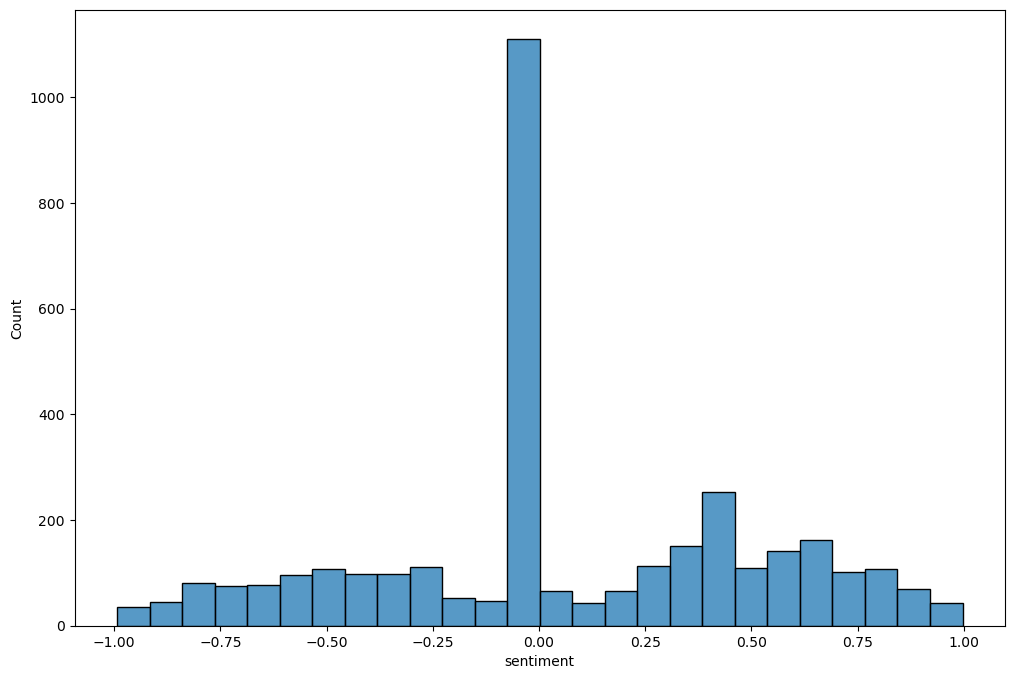

In [43]:
plt.figure(figsize=(12,8))
sns.histplot(data=comments_df, x='sentiment')

In [44]:
text = nlp(" ".join(comments_df['comment'].values))

In [45]:
lemmas = [token.lemma_.strip().lower() for token in text if token.lemma_ if 
                ( not (token.is_stop) and (token.is_alpha) and token.__len__() >2 )
                ]

In [46]:
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(" ".join(lemmas))

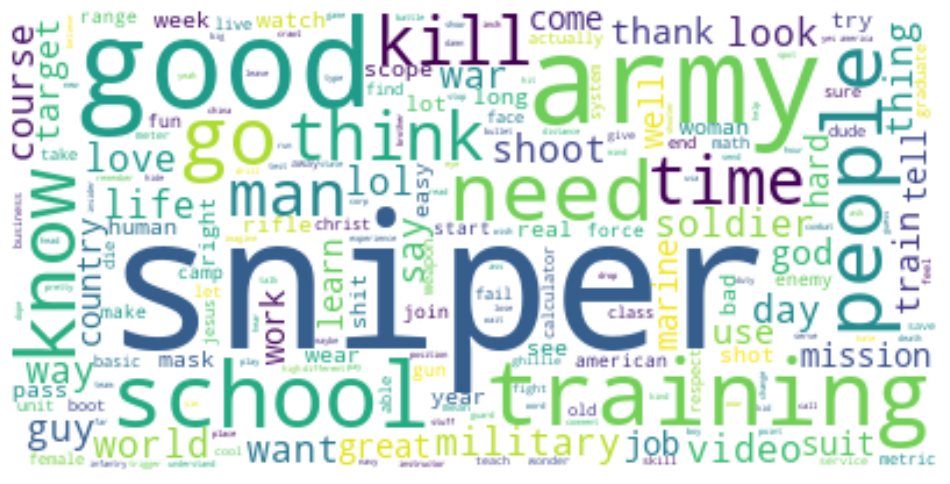

In [47]:
plt.figure(figsize=(12,10))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [48]:
c = Counter(lemmas)
c.most_common(10)

[('sniper', 763),
 ('like', 287),
 ('army', 251),
 ('good', 249),
 ('training', 236),
 ('school', 222),
 ('need', 189),
 ('go', 182),
 ('people', 180),
 ('know', 177)]

In [49]:
comments_df.to_csv("BI_video_youtube_comments.csv")